In [25]:
#Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array

In [26]:
#Load Image HAM10000 Datasets
base_dir = os.path.join('Dataset')

benign_dir = os.path.join(base_dir, 'train','benign')
malignant_dir = os.path.join(base_dir, 'train', 'malignant') 
normal_dir = os.path.join(base_dir, 'train','normal')

print('total training benign images:', len(os.listdir(benign_dir)))
print('total training malignant images:', len(os.listdir(malignant_dir)))
print('total training normal images:', len(os.listdir(normal_dir)))

total training benign images: 640
total training malignant images: 890
total training normal images: 93


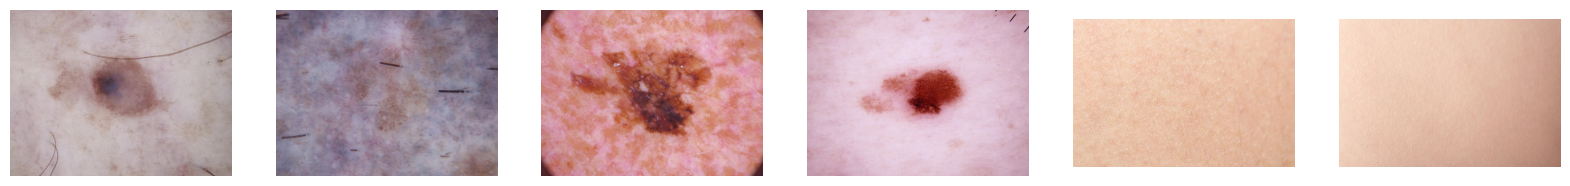

In [27]:

pic_index = 2

benign_files = os.listdir(benign_dir)
malignant_files = os.listdir(malignant_dir)
normal_files = os.listdir(normal_dir)

next_benign = [os.path.join(benign_dir, fname) 
                for fname in benign_files[pic_index-2:pic_index]]
next_malignant = [os.path.join(malignant_dir, fname) 
                for fname in malignant_files[pic_index-2:pic_index]]
next_normal = [os.path.join(normal_dir, fname) 
                for fname in normal_files[pic_index-2:pic_index]]

fig, axs = plt.subplots(1, len(next_benign + next_malignant + next_normal), figsize=(20,7))

for i, img_path in enumerate(next_benign + next_malignant + next_normal):
    img = mpimg.imread(img_path)
    axs[i].imshow(img)
    axs[i].axis('off')

In [28]:
model = Sequential([
    tf.keras.layers.Conv2D(64, (3,3), 1, activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.Conv2D(64, (3,3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), 1, activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 98, 98, 64)        1792      
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 conv2d_8 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                  

In [29]:
model.compile(optimizer = Adam(learning_rate=0.0001),
              loss = "categorical_crossentropy",
              metrics=["accuracy"])

In [30]:
#Image Augmented
from keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = os.path.join(base_dir, 'train')
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = os.path.join(base_dir, 'test')
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(100,100),
	class_mode='categorical',
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(100,100),
	class_mode='categorical', 
  batch_size=126
)

Found 1623 images belonging to 3 classes.
Found 408 images belonging to 3 classes.


In [31]:
# Train the model
history = model.fit(train_generator, epochs=25, validation_data = validation_generator, verbose = 1)

Epoch 1/25
13/13 [==============================] - 82s 6s/step - loss: 0.9229 - accuracy: 0.5219 - val_loss: 0.8463 - val_accuracy: 0.6863
Epoch 2/25
13/13 [==============================] - 73s 6s/step - loss: 0.8104 - accuracy: 0.6562 - val_loss: 0.7317 - val_accuracy: 0.7672
Epoch 3/25
13/13 [==============================] - 75s 6s/step - loss: 0.7706 - accuracy: 0.6685 - val_loss: 0.6924 - val_accuracy: 0.7475
Epoch 4/25
13/13 [==============================] - 76s 6s/step - loss: 0.7258 - accuracy: 0.6925 - val_loss: 0.6350 - val_accuracy: 0.7500
Epoch 5/25
13/13 [==============================] - 74s 6s/step - loss: 0.6745 - accuracy: 0.7024 - val_loss: 0.5990 - val_accuracy: 0.7328
Epoch 6/25
13/13 [==============================] - 73s 5s/step - loss: 0.6214 - accuracy: 0.7110 - val_loss: 0.5067 - val_accuracy: 0.7647
Epoch 7/25
13/13 [==============================] - 78s 6s/step - loss: 0.5828 - accuracy: 0.7240 - val_loss: 0.5092 - val_accuracy: 0.7525
Epoch 8/25
13/13 [==

In [32]:
loss, accuracy = model.evaluate(train_generator, verbose=1)
val_loss, val_acc = model.evaluate(validation_generator, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
print("Validation: accuracy = %f  ;  loss = %f" % (val_acc, val_loss))
model.save("model.h5")
model.save_weights('weights.h5')

4/4 [==============================] - 7s 1s/step - loss: 0.3473 - accuracy: 0.8578
Test: accuracy = 0.826248  ;  loss = 0.408541
Validation: accuracy = 0.857843  ;  loss = 0.347344


C:\Users\Salsabiela\AppData\Local\Temp\ipykernel_21376\2744701137.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


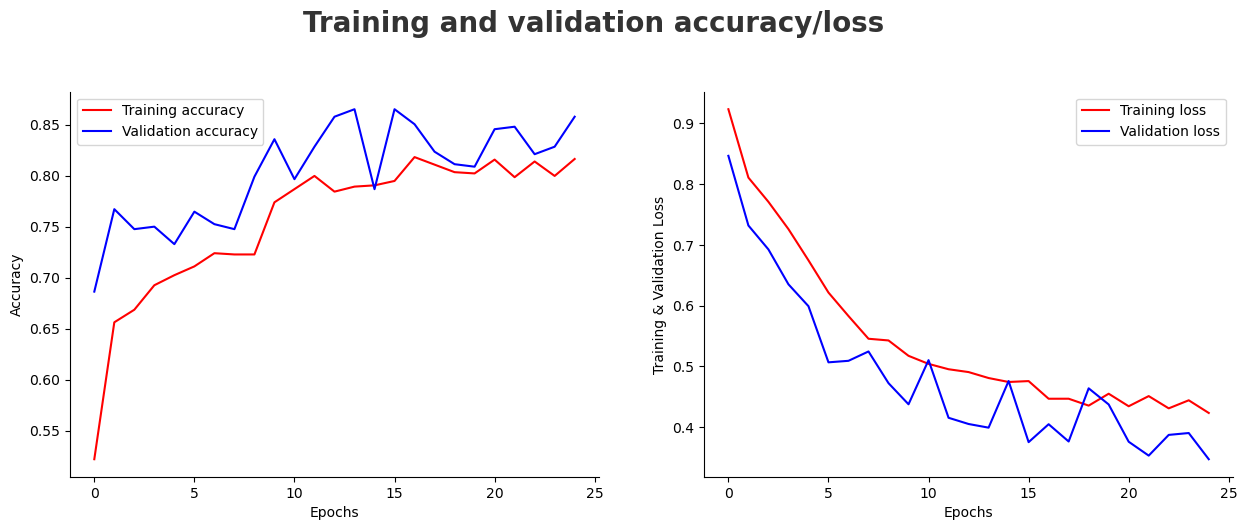

In [33]:
# Plot the results
import seaborn as sns
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
fig, ax = plt.subplots(1,2, figsize=(15, 5))
fig.text(s='Training and validation accuracy/loss', size=20, fontweight='bold',
          y=1, x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].legend(loc=0)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, loss, 'r', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].legend(loc=0)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [34]:
#Define Path
model_path = "model.h5"
model_weights_path = 'weights.h5'
input = 'data_test\ISIC_0024545.jpg' #input path

#Load model and weight
model = load_model(model_path)
model.load_weights(model_weights_path)


In [35]:
#Prediction Function

def img_pred(file):
    x = load_img(file, target_size=(100,100))
    x = img_to_array(x)
    x = np.expand_dims(x, axis=0)
    array = model.predict(x)
    result = array[0]
    classes = np.argmax(result)
    print(classes)
    if classes == 0:
        print("Predicted: Benign")
    elif classes == 1:
        print("Predicted: Malignant")
    elif classes == 2:
        print("Predicted: Normal")
    else:
        print("not predicted")
    return classes

predicted = img_pred(input)
print(" ")

1/1 [==============================] - 0s 377ms/step
1
Predicted: Malignant
 


In [36]:
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import *

button = widgets.Button(description="Predict")
out = widgets.Output()
uploader = widgets.FileUpload()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
        except:
            print("no image uploaded")
display(uploader)

FileUpload(value={}, description='Upload')

In [37]:
button.on_click(on_button_clicked)
widgets.VBox([button, out])